### Importation de librairies

In [11]:
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [12]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

In [13]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


In [14]:
#bins / nombre d'intervalles
n_interval = 10

#récupération de paramètres
latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y = ds.calcul_param(df)

#On sépare en n_interval la latitude et la longitude
x_splits = np.linspace(latitude_min,latitude_max, n_interval)
y_splits = np.linspace(longitude_min,longitude_max, n_interval)

## Modèles

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataSource import *
from sklearn.metrics import mean_squared_error
#fichier contenant des classes pour transformer et evaluer les données
import Eval
from physic_model import *

In [16]:
#on prend un point sur 'step' du jeu de données
freq_train = 200
freq_test = freq_train

train_size = 0.8

#features
attrs_x = [['Latitude','Longitude','GpsSpeed','GpsHeading'],['Latitude','Longitude']]

#targets
labels = ['Latitude','Longitude']

#models
#models = [LinearRegression(), physic_model(freq)]
models = [LinearRegression(), LinearRegression()]

#preprocessing
#preprocessor = [MinMaxScaler() for _ in range(len(models))]
preprocessor = None

In [17]:
#création des données d'apprentissage et de test pour la prédiction du prochain point (à partir de toutes nos données)
traitement = Eval.Traitement(df, attrs_x, labels, freq_train, freq_test, preprocessor)
traitement.set_data_train_test(train_size)

#Apprentissage des modèles et évaluation à partir de l'objet traitement
evaluateur = Eval.Evaluation(models,traitement)
evaluateur.fit()

#Affichage des résultats
evaluateur.afficher_resultats()

Score obtenu pour le modèle 0          : 0.9972659268838032
Score obtenu pour le modèle 1          : 0.9972583024470235

MSE obtenue pour le modèle  0          : 3.969479019628803e-09
MSE obtenue pour le modèle  1          : 3.980547871058858e-09



Matrice l'erreur MSE pour chaque label :


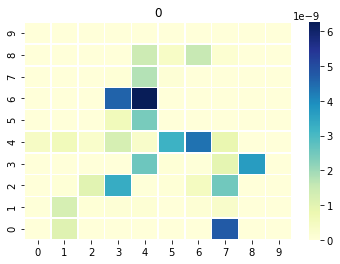

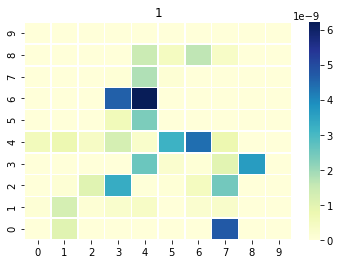

In [18]:
from sklearn.metrics import mean_squared_error

# liste matrices erreurs des cases
l_mat_err= [np.zeros((n_interval, n_interval)) for i in range(len(models))]
# parcours de toutes les cases
for i in range(n_interval):
    for j in range(n_interval):
        # récupération des données de la case
        case_df=ds.trouve_data_case(df, (i, j), latitude_min, longitude_min, ecart_x, ecart_y)
        
        #On prend les Trips qui ont au moins 2 points
        ctrips, ccounts = np.unique(case_df["Trip"], return_counts=True)
        ctrips = ctrips[ccounts>1]
        case_df = case_df[case_df['Trip'].isin(ctrips)]
        
        #Cases qui ont au moins 2 trips
        if len(pd.unique(case_df["Trip"])) > 1 :
            traitement = Eval.Traitement(case_df, attrs_x, labels, freq_train, freq_test, preprocessor)
            traitement.set_data_train_test(train_size)
            
            l_ypred = evaluateur.predict(traitement.l_Xtest)

            for mi in range(len(models)):               
                l_mat_err[mi][n_interval-1-i, j] = mean_squared_error(traitement.l_Ytest[mi],l_ypred[mi])

print("Matrice l'erreur MSE pour chaque label :")
for m in range(len(l_mat_err)):
    plt.figure()
    plt.title(m)
    sns.heatmap(l_mat_err[m], linewidths=.5, cmap="YlGnBu", yticklabels=np.arange(n_interval-1, -1, -1))

0


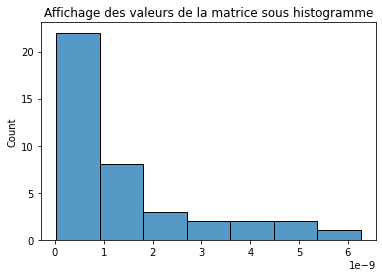

1


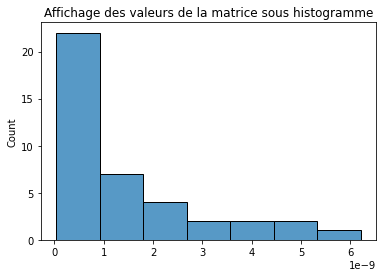

In [19]:
for mi in range(len(l_mat_err)):
    print(mi)
    dv.afficher_mat_hist(l_mat_err[mi])